Epochs: 5
Batch size: 128
Batches per epoch: 468


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


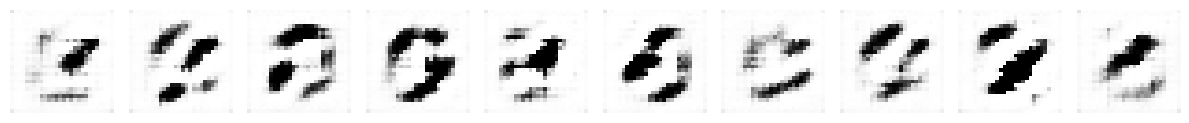

Epoch 2/5


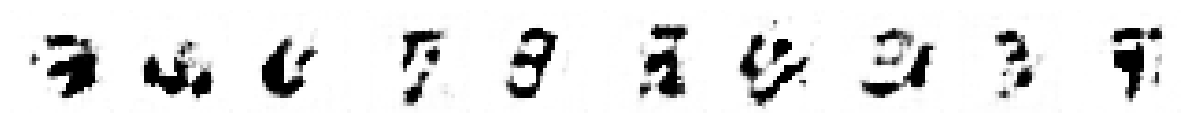

Epoch 3/5


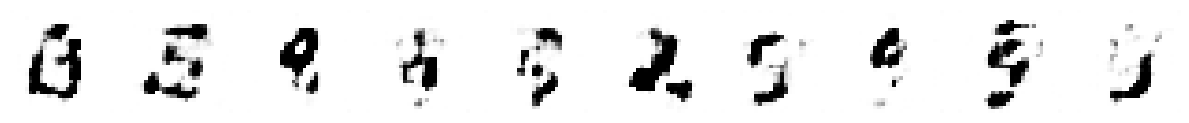

Epoch 4/5


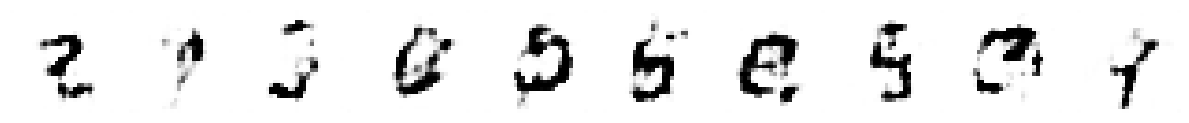

Epoch 5/5


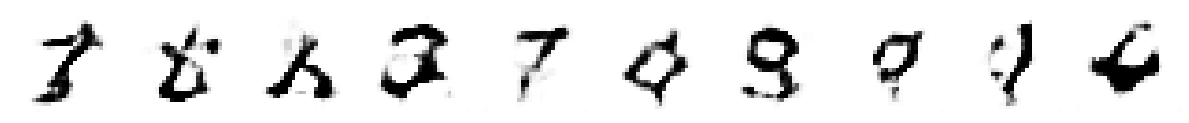

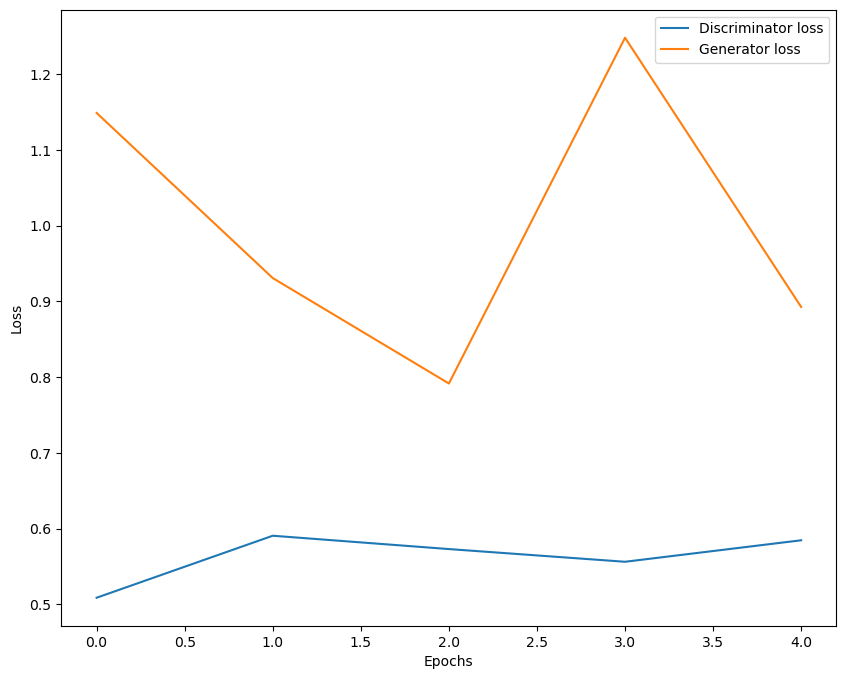

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LeakyReLU, Reshape,
                                     Flatten, Conv2D, Conv2DTranspose, BatchNormalization)
from tensorflow.keras.optimizers.legacy import Adam  # Use legacy optimizer

# Suppress logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Load and preprocess the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5  # Normalize to [-1, 1]

z_dim = 100  # Dimension of the noise vector

# Create separate optimizers for the discriminator and the GAN
adam_d = Adam(learning_rate=0.0002, beta_1=0.5)
adam_g = Adam(learning_rate=0.0002, beta_1=0.5)

# GENERATOR
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(7 * 7 * 128, input_dim=z_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))
    
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh'))
    return model

# DISCRIMINATOR
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build and compile the discriminator
d = build_discriminator()
d.compile(loss='binary_crossentropy', optimizer=adam_d, metrics=['accuracy'])

# Build the generator
g = build_generator(z_dim)

# Build and compile the GAN
d.trainable = False  # Freeze the discriminator's weights during GAN training
gan_input = Input(shape=(z_dim,))
generated_image = g(gan_input)
gan_output = d(generated_image)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=adam_g)

# Visualization functions
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = losses["G"]
    plt.figure(figsize=(10, 8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2), z_dim=100):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise, verbose=0)
    generated_images = 0.5 * generated_images + 0.5  # Rescale images to [0, 1]
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Training the GAN
losses = {"D": [], "G": []}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128, z_dim=100):
    batch_count = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batch_count)

    for e in tqdm(range(1, epochs + 1)):
        for _ in range(batch_count):
            # Get a random set of real images
            idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
            real_images = X_train[idx]

            # Generate fake images
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            fake_images = g.predict(noise, verbose=0)

            # Combine real and fake images
            X = np.concatenate([real_images, fake_images])

            # Labels for real and fake images
            y_dis = np.zeros(2 * BATCH_SIZE)
            y_dis[:BATCH_SIZE] = 1  # Real images label

            # Train the discriminator
            d_loss = d.train_on_batch(X, y_dis)

            # Train the generator via GAN
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y_gen = np.ones(BATCH_SIZE)  # The generator wants the discriminator to output 1
            g_loss = gan.train_on_batch(noise, y_gen)

        # Store losses
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Plot generated images
        if e % plt_frq == 0:
            print(f'Epoch {e}/{epochs}')
            plot_generated(z_dim=z_dim)

    plot_loss(losses)

# Train the GAN
train(epochs=5, plt_frq=1, BATCH_SIZE=128, z_dim=z_dim)
